# Introduction

* Lung cancer is a type of cancer that starts in the lungs, which are two spongy organs located in the chest that help us breathe. There are two main types of lung cancer: non-small cell lung cancer (NSCLC) and small cell lung cancer (SCLC). NSCLC is the most common type, accounting for around 85% of all lung cancers, while SCLC is a less common but more aggressive type.

* Lung cancer can develop when cells in the lungs grow and divide uncontrollably, forming a tumor. These tumors can then spread to other parts of the body, such as the lymph nodes, bones, or brain. Lung cancer is a serious and often deadly disease, with smoking being the leading cause of most cases. Other risk factors include exposure to secondhand smoke, air pollution, radon gas, and asbestos. Symptoms of lung cancer can include coughing, chest pain, shortness of breath, and weight loss.

* Early detection and treatment are important for improving the chances of survival, so it's important to speak with a healthcare provider if you have any concerns about lung cancer.

<center> <img   width="1100"  src="https://d3i71xaburhd42.cloudfront.net/08c1efb98130ce623ac809d9d5e3d16477a99de7/4-Figure1-1.png" alt="Alternative text" /> </center>
<br></br>


# Motivation 

* Lung cancer often doesn't cause noticeable symptoms until it has progressed to an advanced stage, making it more difficult to treat. However, when lung cancer is detected early, there is a greater chance of successful treatment and long-term survival.

* Screening tests, such as low-dose computed tomography (LDCT) scans, can detect lung cancer in its early stages, even before symptoms appear. The American Cancer Society recommends yearly LDCT screening for people who meet certain criteria, such as current or former smokers between the ages of 55 and 80 years old who have a history of smoking.

* Early treatment of lung cancer can also help to reduce the risk of complications associated with the disease. These complications can include shortness of breath, coughing up blood, chest pain, and difficulty swallowing. Treatment options for lung cancer include surgery, radiation therapy, chemotherapy, targeted therapy, and immunotherapy.

* Overall, early detection and treatment of lung cancer can help to improve the chances of survival and reduce the impact of the disease on a person's quality of life. It's important for individuals who are at high risk of lung cancer to talk to their healthcare provider about screening and to seek medical attention if they experience any symptoms associated with the disease

# EDA

* The First Step is Exploratory Data Analysis (EDA). It helps us analyse the entire dataset and summarise its main characteristics, like class distribution, size distribution, and so on. Visual methods are often used to display the results of this analysis.

* The second step is Image Pre-Processing, where the aim is to take the raw image and improve image data (also known as image features) by suppressing unwanted distortions, resizing and/or enhancing important features, making the data more suited to the model and improving performance. 

* Exploratory data analysis comprises brief analyses to describe a dataset to guide the modeling process and to answer preliminary questions. For classification problems, this might include looking at the distributions of variables or checking for any meaningful patterns of predictors across different classes. The same problem holds for the classification of image data. We intend to find meaningful information 

# **Imports**

In [2]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

# **Data Preparation**

In [7]:
folders = glob('C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets/' + '/*')
print('New Paths: ', folders)

IMAGE_FILES = glob('C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets/' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))

New Paths:  ['C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets\\lung_aca', 'C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets\\lung_n', 'C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets\\lung_scc']
Images Count:  15000


# **Showing Sample Images**

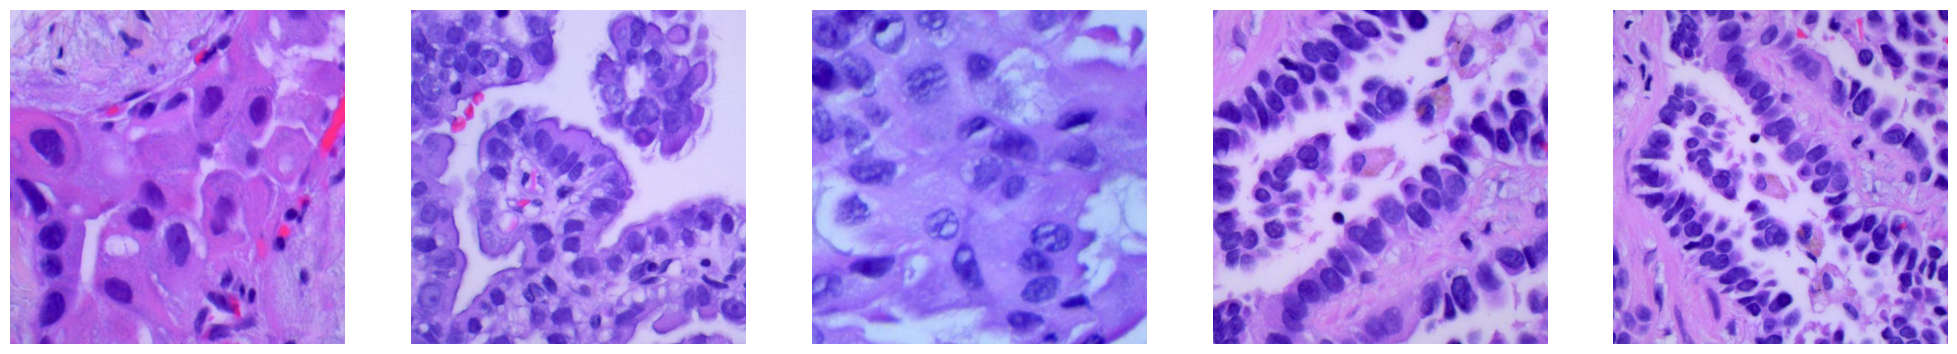

In [6]:
SAMPLES = ["C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1.jpeg",
           'C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets/lung_aca/lungaca10.jpeg', 
           'C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1000.jpeg',
           'C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1006.jpeg', 
           'C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1007.jpeg']

plt.figure(figsize=(25, 10)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

# **Generating Data**

In [8]:
# data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
data_dir = 'C:/Users/sanket/Desktop/Programming/Python/dataset/lung_colon_image_set/lung_image_sets/'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 299

training = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

In [10]:
IMG_SHAPE = (X,Y) +(3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')


87910968/87910968 [==============================] - 223s 3us/step


In [11]:
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [12]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name) 

Numbers of Layers = 311
activation_93
mixed10


In [13]:
# iterate over first batch (32 image) in trainset 
image_batch, label_batch = next(iter(training))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 8, 8, 2048)


In [14]:
def ChestCancer_Model( image_shape=(X,Y)):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)
    
    resnet_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 290]:
        layer.trainable = False
    
    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(3 ,activation = "softmax") 
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs) 
    model.summary()
    return model

In [15]:
ChestCancer_Model = ChestCancer_Model((X,Y))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [17]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)
                        
checkpoint=tf.keras.callbacks.ModelCheckpoint(
     './checkpoints', 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    period=5
)
callback=[earlystop,checkpoint,tensorboard_callback]

In [18]:
import keras 
base_learning_rate = 0.001
ChestCancer_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy' , tf.keras.metrics.Precision()])

In [19]:
history = ChestCancer_Model.fit(training , verbose=1 , epochs=15,
                               validation_data=validation , use_multiprocessing= True, callbacks=callback)

Epoch 1/15



c:\Users\sanket\anaconda3\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Exception in thread Thread-27 (_run):
Traceback (most recent call last):
  File "c:\Users\sanket\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\sanket\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\sanket\anaconda3\Lib\site-packages\keras\src\utils\data_utils.py", line 829, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sanket\anaconda3\Lib\site-packages\keras\src\utils\data_utils.py", line 804, in pool_fn
    pool = get_pool_class(True)(
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sanket\anaconda3\Lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sanket\anaconda3\Lib\multiprocessing\pool.py", line 215, in __init__
    self._re

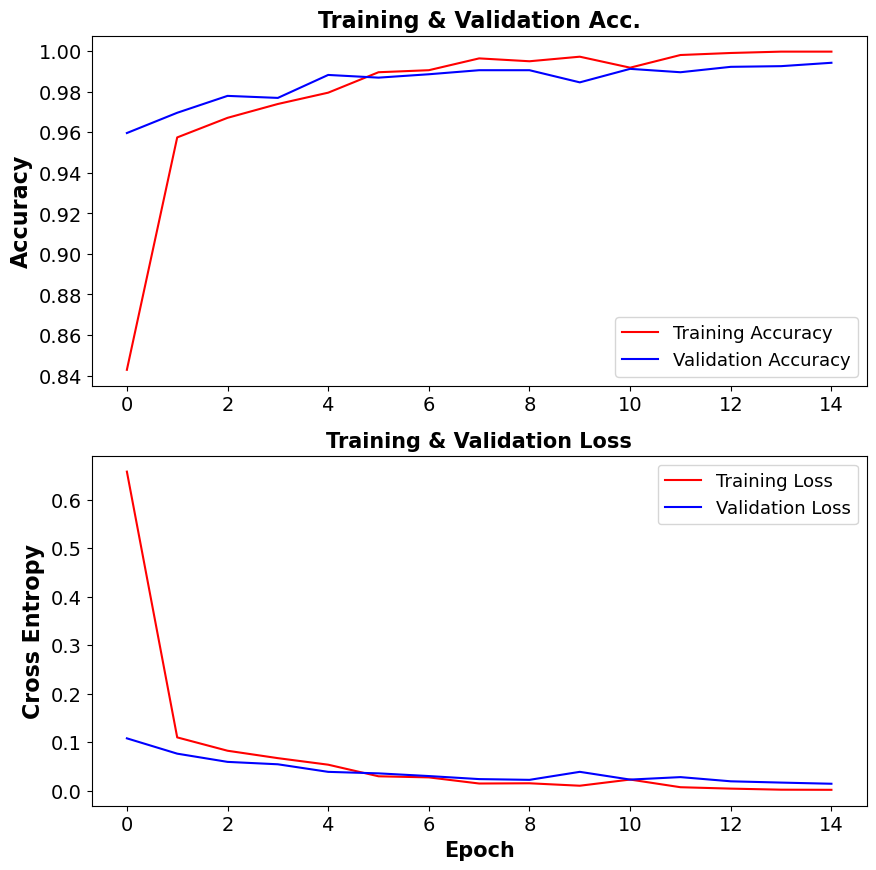

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

# **Classification Report**

In [16]:
from sklearn.metrics import classification_report

Y_pred = ChestCancer_Model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

24/24 [==============================] - 315s 13s/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       1.00      1.00      1.00      1000
           2       0.99      0.99      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



# **Confusion Matrix**

Normalized confusion matrix


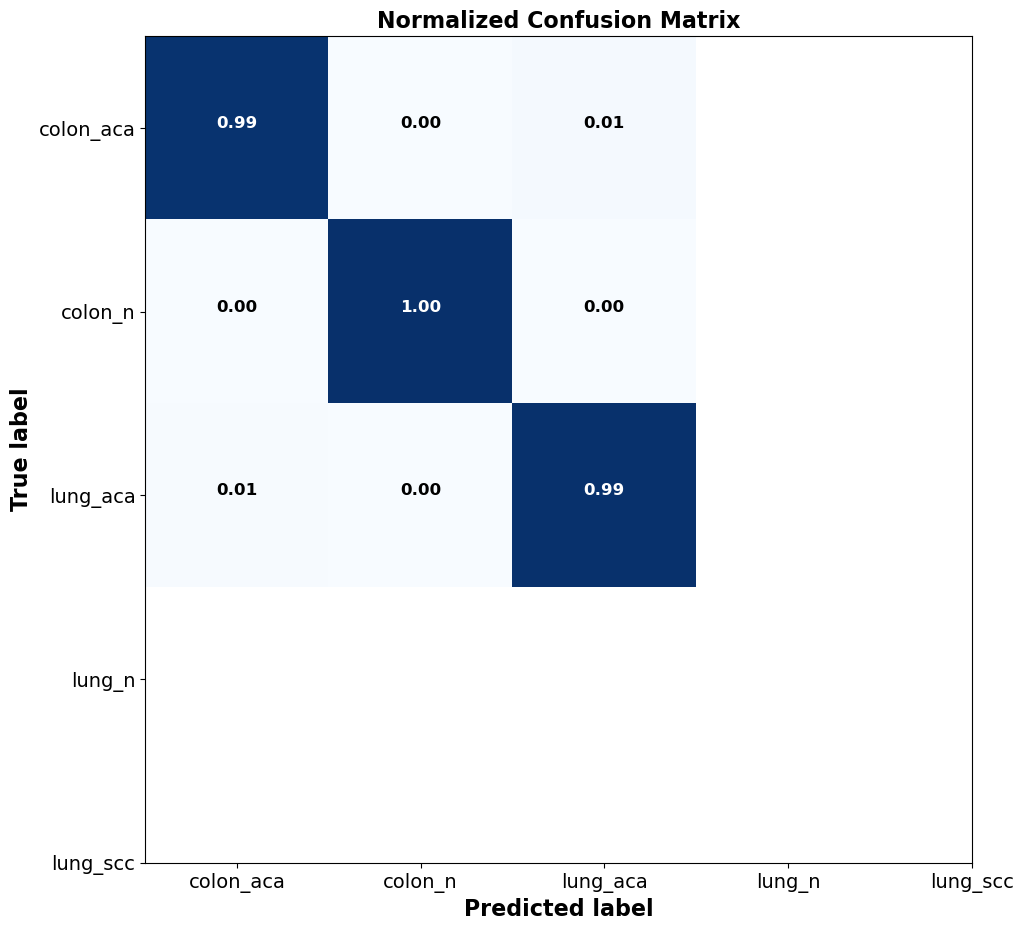

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()